In [1]:
#!pip install kagglehub\[pandas-datasets\]
#!pip3 install torch torchvision torchaudio
#!pip3 install matplotlib
#!pip3 install pillow
#!pip3 install scikit-learn
#!pip3 install seaborn

In [2]:
import kagglehub
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Subset
import torchvision.transforms as T
from torch.utils.data import ConcatDataset
from torchvision.datasets import ImageFolder
import os 
from PIL import Image, UnidentifiedImageError
import warnings
from torch.utils.data import ConcatDataset, random_split, DataLoader, Dataset
from torchvision import models
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from typing import List
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix

/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!pip install --upgrade certifi
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
torch.mps.empty_cache()
gc.collect() 

20

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [6]:

def is_valid_image(filepath):
    """Verify if an image file is valid by trying to open it with PIL."""
    try:
        img = Image.open(filepath)
        return True
    except (UnidentifiedImageError, IOError, SyntaxError, ValueError, Image.DecompressionBombError) as e:
        return False



In [7]:
def delete_corrupted_images(folder):
    """Delete corrupted images in folder and subfolders"""
    image_exts = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    
    for root, _, files in os.walk(folder):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_exts:
                filepath = os.path.join(root, file)
                if not is_valid_image(filepath):
                    os.remove(filepath)
                    print(f"Deleted corrupted: {filepath}")


<h1 style="color:#30e66a;">Downloading Dataset</h1>

In [8]:
# Download latest version
path = kagglehub.dataset_download("occultainsights/toyota-cars-over-20k-labeled-images")

print("Path to dataset files:", path)

dataset_path = path + "/toyota_image_dataset_v2/toyota_cars"

Path to dataset files: /Users/mahdi/.cache/kagglehub/datasets/occultainsights/toyota-cars-over-20k-labeled-images/versions/4


In [9]:
delete_corrupted_images(dataset_path)

<h1 style="color:#30e66a;">Loading Dataset and Normalization</h1>

#### The ToTensoe instace will automatically normalize the pixels into 0 to 1 

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

In [11]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform )

#### Each Car Model using the Dataloader have been converted into a number

In [12]:
dataset.class_to_idx

{'4runner': 0,
 'alphard': 1,
 'avalon': 2,
 'avanza': 3,
 'avensis': 4,
 'aygo': 5,
 'camry': 6,
 'celica': 7,
 'corolla': 8,
 'corona': 9,
 'crown': 10,
 'estima': 11,
 'etios': 12,
 'fortuner': 13,
 'hiace': 14,
 'highlander': 15,
 'hilux': 16,
 'innova': 17,
 'iq': 18,
 'matrix': 19,
 'mirai': 20,
 'previa': 21,
 'prius': 22,
 'rav4': 23,
 'revo': 24,
 'rush': 25,
 'sequoia': 26,
 'sienna': 27,
 'soarer': 28,
 'starlet': 29,
 'supra': 30,
 'tacoma': 31,
 'tundra': 32,
 'venza': 33,
 'verso': 34,
 'vios': 35,
 'vitz': 36,
 'yaris': 37}

In [13]:
len(dataset)

16708

In [14]:
label_map = {}
for i in dataset.class_to_idx.items():
    label_map.update({i[1]: i[0]})

In [15]:
label_map

{0: '4runner',
 1: 'alphard',
 2: 'avalon',
 3: 'avanza',
 4: 'avensis',
 5: 'aygo',
 6: 'camry',
 7: 'celica',
 8: 'corolla',
 9: 'corona',
 10: 'crown',
 11: 'estima',
 12: 'etios',
 13: 'fortuner',
 14: 'hiace',
 15: 'highlander',
 16: 'hilux',
 17: 'innova',
 18: 'iq',
 19: 'matrix',
 20: 'mirai',
 21: 'previa',
 22: 'prius',
 23: 'rav4',
 24: 'revo',
 25: 'rush',
 26: 'sequoia',
 27: 'sienna',
 28: 'soarer',
 29: 'starlet',
 30: 'supra',
 31: 'tacoma',
 32: 'tundra',
 33: 'venza',
 34: 'verso',
 35: 'vios',
 36: 'vitz',
 37: 'yaris'}

#### An example of data : 

In [16]:
dataset[4098]

(tensor([[[0.5765, 0.5765, 0.5725,  ..., 0.5333, 0.5333, 0.5333],
          [0.5725, 0.5765, 0.5725,  ..., 0.5333, 0.5333, 0.5333],
          [0.5765, 0.5765, 0.5765,  ..., 0.5412, 0.5412, 0.5373],
          ...,
          [0.6078, 0.6078, 0.6118,  ..., 0.6471, 0.6471, 0.6431],
          [0.6039, 0.6078, 0.6118,  ..., 0.6431, 0.6431, 0.6392],
          [0.6000, 0.6039, 0.6078,  ..., 0.6431, 0.6431, 0.6392]],
 
         [[0.6000, 0.6000, 0.5961,  ..., 0.5569, 0.5569, 0.5569],
          [0.5961, 0.6000, 0.5961,  ..., 0.5569, 0.5569, 0.5569],
          [0.6000, 0.6000, 0.6000,  ..., 0.5647, 0.5647, 0.5608],
          ...,
          [0.6196, 0.6196, 0.6235,  ..., 0.6902, 0.6902, 0.6863],
          [0.6157, 0.6196, 0.6235,  ..., 0.6863, 0.6863, 0.6824],
          [0.6118, 0.6157, 0.6196,  ..., 0.6863, 0.6863, 0.6824]],
 
         [[0.6549, 0.6549, 0.6510,  ..., 0.6196, 0.6196, 0.6196],
          [0.6510, 0.6549, 0.6510,  ..., 0.6196, 0.6196, 0.6196],
          [0.6549, 0.6549, 0.6549,  ...,

In [17]:
label_map.get(dataset[4098][1])

'celica'

<h1 style="color:#30e66a;">Distribution Chart</h1>

In [18]:

def plot_label_distribution(dataset):

    labels = [label for _, label in dataset]
    label_counts = Counter(labels)

    classes = list(label_counts.keys())
    counts = list(label_counts.values())

    sorted_classes = sorted(classes)
    sorted_counts = [label_counts[c] for c in sorted_classes]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_classes, sorted_counts, color='skyblue')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Images')
    plt.title('Label Distribution of Dataset')
    plt.xticks(sorted_classes)
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2, str(count),
                 ha='center', va='bottom', color='black', fontsize=10, rotation=90)

    plt.show()


/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


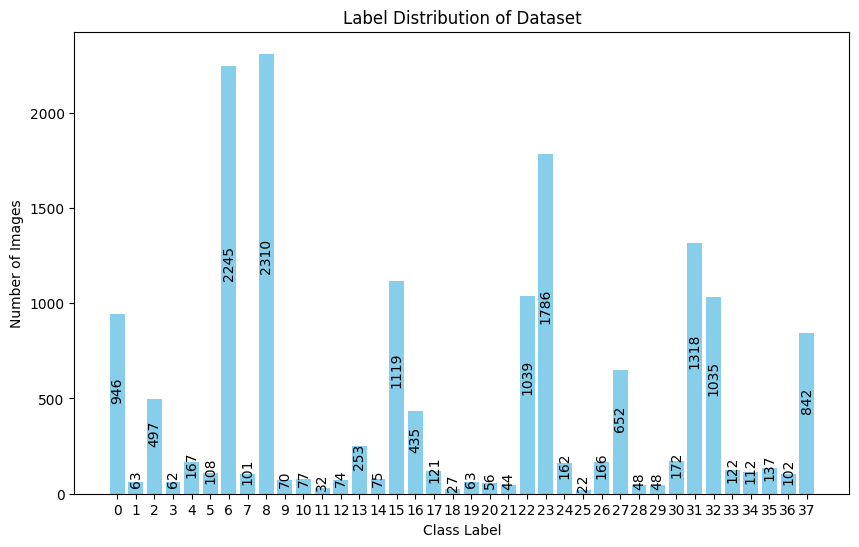

In [19]:
plot_label_distribution(dataset=dataset)

<h1 style="color:#30e66a;">Pick Top 10 Classes Based on Distribution </h1>

In [19]:
counter = Counter(dataset.targets)


top_10 = counter.most_common(10)
top_10_labels = [label for label, count in top_10]
print("Top 10 class indices:", top_10_labels)
print("Corresponding class names:", [dataset.classes[label] for label in top_10_labels])


Top 10 class indices: [8, 6, 23, 31, 15, 22, 32, 0, 37, 27]
Corresponding class names: ['corolla', 'camry', 'rav4', 'tacoma', 'highlander', 'prius', 'tundra', '4runner', 'yaris', 'sienna']


In [20]:
original_labels_to_new_labels = {label: idx for idx, label in enumerate(top_10_labels)}

In [21]:
original_labels_to_new_labels

{8: 0, 6: 1, 23: 2, 31: 3, 15: 4, 22: 5, 32: 6, 0: 7, 37: 8, 27: 9}

In [22]:
class Top10RemappedDataset(Dataset):
    def __init__(self, original_dataset, label_mapping):
        self.original_dataset = original_dataset
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, original_label = self.original_dataset[idx]
        new_label = self.label_mapping[original_label] 
        return img, new_label

<h1 style="color:#30e66a;">Data Augmentation</h1>

In [23]:
def plot_an_image (image , label):
    image_np = image.permute(1, 2, 0).numpy()
    plt.figure(figsize=(10, 5))

    plt.imshow(image_np)
    plt.title(str(label) + " - " + label_map.get(label))
    plt.axis('off')
    plt.show()

In [24]:
sample_image , sample_class = dataset[9010][0], dataset[9010][1]

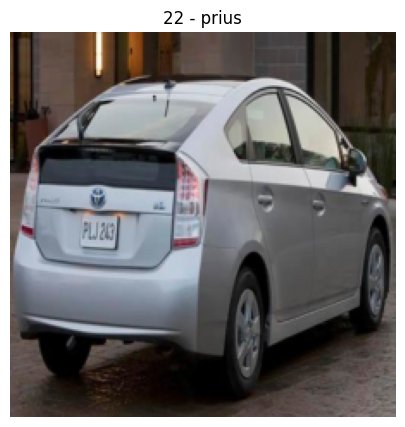

In [25]:
plot_an_image(sample_image , sample_class)

In [26]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.7), # I have not use Vertical Flip becuase cars are not in vertical mood :)
    transforms.RandomRotation(30), 
    transforms.RandomResizedCrop(224, scale=(0.7 , 1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

])

In [27]:
train_transforms(sample_image).size() == sample_image.size()

True

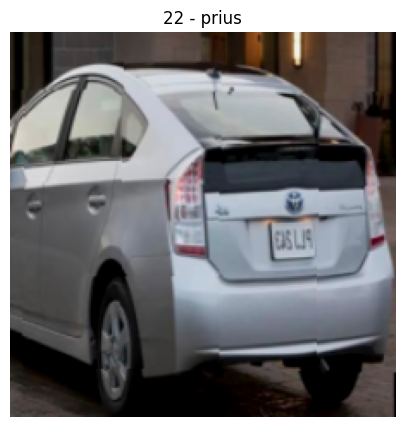

In [28]:
plot_an_image(train_transforms(sample_image), sample_class)

In [29]:
class AugmentedDataset(datasets.ImageFolder):
    def __init__(self, original_dataset:datasets.ImageFolder, augmentation_transform, augmentation_number=2):
        self.original_dataset = original_dataset
        self.augmentation_transform = augmentation_transform
        self.augmentation_number = augmentation_number

        self.data = []
        for img_path, label in original_dataset:
            for _ in range(self.augmentation_number):
                self.data.append((self.augmentation_transform(img_path), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [30]:
augmented_dataset = AugmentedDataset(original_dataset=dataset, augmentation_transform=train_transforms, augmentation_number=1)

/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


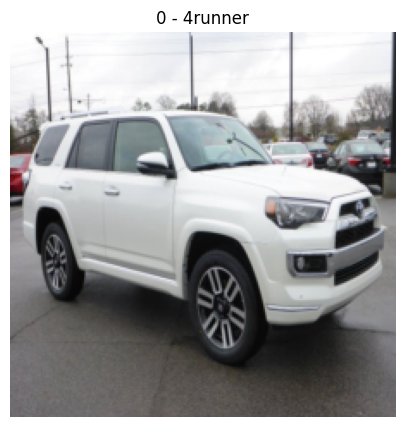

In [31]:
plot_an_image(dataset[0][0],dataset[0][1])

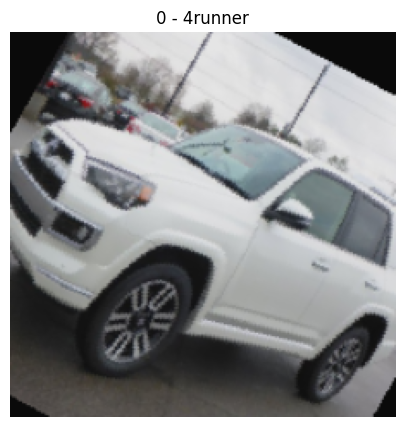

In [32]:
plot_an_image(augmented_dataset[0][0], augmented_dataset[0][1])

In [33]:
total_dataset = ConcatDataset([ dataset , augmented_dataset] )

In [34]:
len(total_dataset)

33416

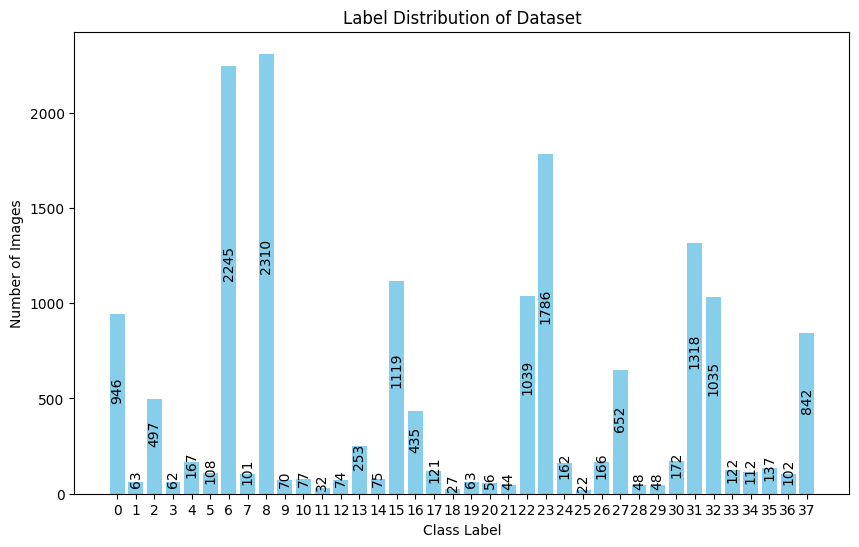

In [36]:
plot_label_distribution(augmented_dataset)

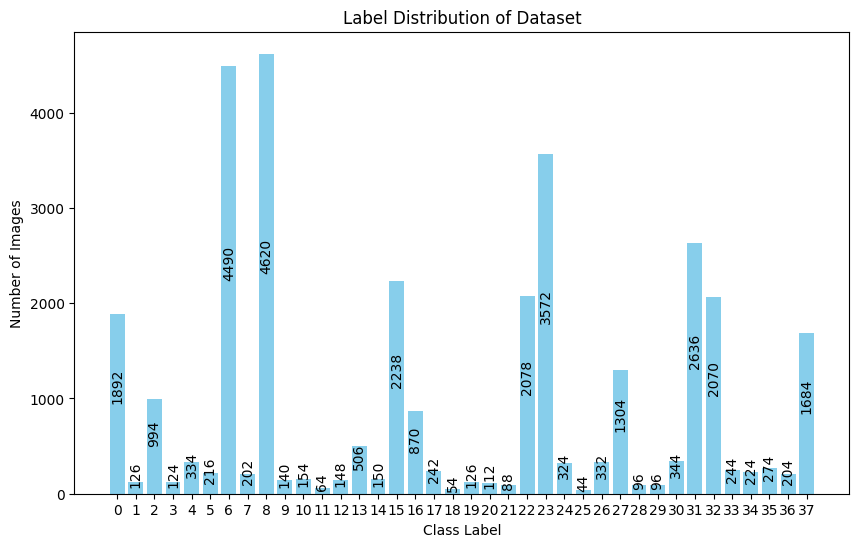

In [37]:
plot_label_distribution(total_dataset)

### Top 10 Classes

In [35]:
top10_indices = [idx for idx, ds in enumerate(total_dataset) if ds[1] in top_10_labels]

In [36]:
subset_dataset = Subset(total_dataset,top10_indices)

total_dataset = Top10RemappedDataset(
                        original_dataset=subset_dataset, 
                        label_mapping=original_labels_to_new_labels
                    )

In [37]:
print("label mapping is : " , original_labels_to_new_labels)

label mapping is :  {8: 0, 6: 1, 23: 2, 31: 3, 15: 4, 22: 5, 32: 6, 0: 7, 37: 8, 27: 9}


In [38]:
len(total_dataset)

26584

In [39]:
len(subset_dataset)

26584

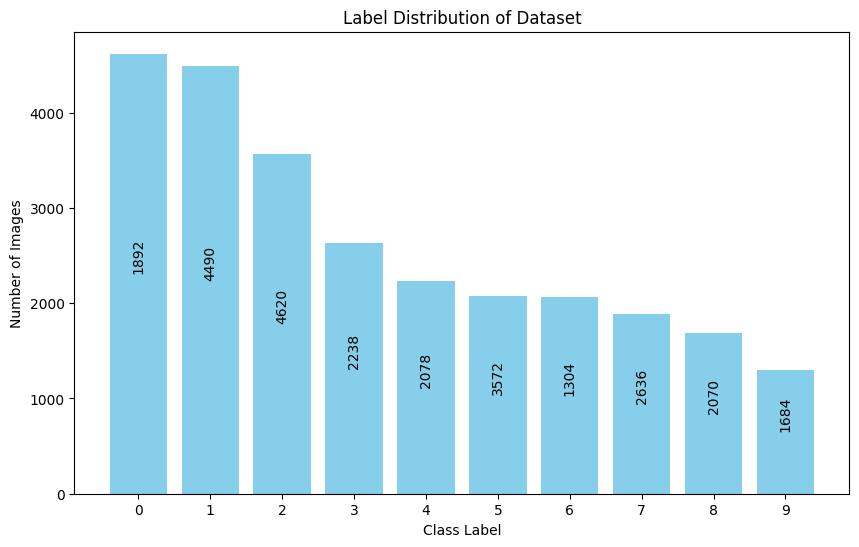

In [42]:
plot_label_distribution(total_dataset)

<h1 style="color:#30e66a;">Split Test And Train Data</h1>

In [40]:
train_ratio = 0.8 
total_size = len(total_dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

print( f"Size of Train : {train_size} - Train Ratio is : {train_ratio}")
print( f"Size of Test : {test_size} - Test Ratio is : {1 - train_ratio}")

Size of Train : 21267 - Train Ratio is : 0.8
Size of Test : 5317 - Test Ratio is : 0.19999999999999996


#### Random Seed

In [41]:

generator = torch.Generator().manual_seed(42)

In [42]:
train_dataset, test_dataset = random_split(total_dataset, [train_size, test_size])

In [43]:
len(train_dataset)/ len(total_dataset)

0.7999924766777009

In [44]:
len(test_dataset)/ len(total_dataset)

0.20000752332229912

In [45]:
#plot_label_distribution(test_dataset)

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


<h1 style="color:#30e66a;">VGG 16 Model Training </h1>

In [62]:
vgg16 = models.vgg16(pretrained=True)

/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [124]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
number_of_car_classes = len(original_labels_to_new_labels)

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=number_of_car_classes)

In [64]:
vgg16 = vgg16.to(device)


### Compute the classes weights for unbalanced loss function 

In [50]:
def compute_weights_of_clases(train_dataset, number_of_car_classes):
    all_labels = [label for _, label in train_dataset]
    class_counts = Counter(all_labels)
    print("Class counts:", class_counts)
    
    class_weights = [0] * number_of_car_classes
    total_samples = len(train_dataset)
    for cls_idx in range(number_of_car_classes):        
        class_weights[cls_idx] = total_samples / (number_of_car_classes * class_counts.get(cls_idx))
    
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)
    return class_weights_tensor

In [51]:
class_weights_tensor = compute_weights_of_clases(train_dataset=train_dataset, number_of_car_classes=number_of_car_classes)
class_weights_tensor

ERROR! Session/line number was not unique in database. History logging moved to new session 2
Class counts: Counter({0: 3716, 1: 3597, 2: 2828, 3: 2078, 4: 1804, 5: 1669, 6: 1666, 7: 1516, 8: 1354, 9: 1039})


tensor([0.5723, 0.5912, 0.7520, 1.0234, 1.1789, 1.2742, 1.2765, 1.4028, 1.5707,
        2.0469], device='mps:0')

In [ ]:
import torch.optim as optim

In [79]:
import torch.nn as nn
import torch.optim as optim

def train_vgg_classifier(train_dataloader, vgg16,class_weights_tensor,  number_of_epochs=10):
    criterion = nn.CrossEntropyLoss(class_weights_tensor)
    optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)

    train_loss_history = []
    train_accuracy_history = []

    for epoch in tqdm(range(number_of_epochs)):
        vgg16.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = 100 * correct / total

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{number_of_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    return train_loss_history, train_accuracy_history


In [80]:
train_loss_history, train_accuracy_history = train_vgg_classifier(
    train_dataloader=train_dataloader, 
    vgg16=vgg16,
    class_weights_tensor=class_weights_tensor, 
    number_of_epochs=10
)۰۰

 10%|████▎                                      | 1/10 [03:33<31:57, 213.08s/it]

Epoch 1/10, Loss: 1.6336, Accuracy: 38.13%


 20%|████████▌                                  | 2/10 [07:29<30:14, 226.78s/it]

Epoch 2/10, Loss: 1.0608, Accuracy: 59.89%


 30%|████████████▉                              | 3/10 [11:25<26:55, 230.82s/it]

Epoch 3/10, Loss: 0.6804, Accuracy: 73.88%


 40%|█████████████████▏                         | 4/10 [19:17<32:36, 326.07s/it]

Epoch 4/10, Loss: 0.4243, Accuracy: 83.19%


 50%|█████████████████████▌                     | 5/10 [26:18<30:02, 360.58s/it]

Epoch 5/10, Loss: 0.2889, Accuracy: 88.88%


 60%|█████████████████████████▊                 | 6/10 [30:14<21:12, 318.03s/it]

Epoch 6/10, Loss: 0.2346, Accuracy: 91.59%


 70%|██████████████████████████████             | 7/10 [34:09<14:32, 290.84s/it]

Epoch 7/10, Loss: 0.2152, Accuracy: 92.10%


 80%|██████████████████████████████████▍        | 8/10 [37:58<09:02, 271.34s/it]

Epoch 8/10, Loss: 0.1767, Accuracy: 93.94%


 90%|██████████████████████████████████████▋    | 9/10 [41:51<04:19, 259.34s/it]

Epoch 9/10, Loss: 0.1620, Accuracy: 94.47%


100%|████████████████████████████████████████| 10/10 [1:01:52<00:00, 371.22s/it]

Epoch 10/10, Loss: 0.1526, Accuracy: 94.81%


In [93]:
vgg16.eval()
correct = 0
total = 0

y_test = []
y_pred = []

with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)

        y_test.extend(labels.cpu().numpy()) 
        y_pred.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%

 36%|██████████████▊                          | 120/333 [00:13<00:28,  7.39it/s]/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|█████████████████████████████████████████| 333/333 [00:36<00:00,  9.00it/s]

Test Accuracy: 67.41%


In [94]:
def plot_acc_loss_for_training(train_loss_history, train_accuracy_history, model_name):
    plt.figure(figsize=(12, 6))
    plt.title(f"{model_name}Training")
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, label='Train Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy History')
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [206]:
def plot_heat_map(cm, model_name):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues',)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

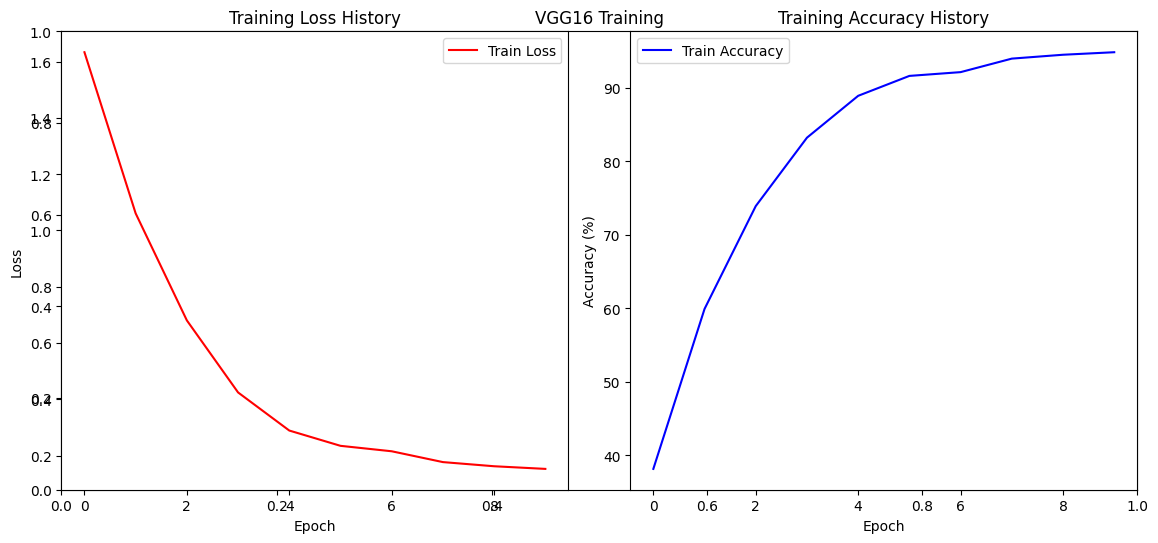

In [207]:
plot_acc_loss_for_training(train_loss_history, train_accuracy_history, "VGG16 " )

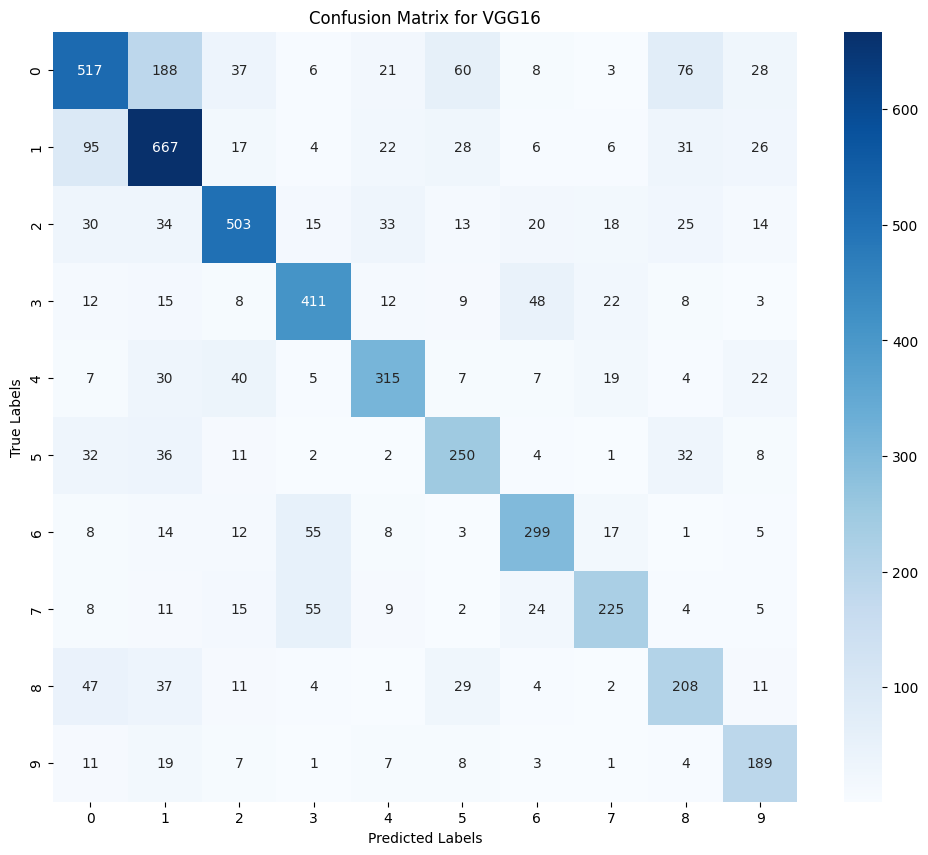

In [208]:
plot_heat_map(cm = confusion_matrix(y_true=y_test, y_pred=y_pred) , model_name="VGG16")

In [209]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"accuracy for VGG16 model is : {accuracy_score(y_true=y_test, y_pred=y_pred)}")

print(f"precision for VGG16 model is : {precision_score(y_true=y_test, y_pred=y_pred, average='macro',) }")

print(f"Recall for VGG16 model is : {recall_score(y_true=y_test, y_pred=y_pred, average='macro',) }")

print(f"F1-Score for VGG16 model is : {f1_score(y_true=y_test, y_pred=y_pred, average='macro',) }")

accuracy for VGG16 model is : 0.6740643219860823
precision for VGG16 model is : 0.6710416323878622
Recall for VGG16 model is : 0.678337070038207
F1-Score for VGG16 model is : 0.672146344943412


<h1 style="color:#30e66a;">Alex Net Model Training </h1>

In [80]:
alex_net = models.alexnet(pretrained=True)

/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [159]:

for param in alex_net.features.parameters():
    param.requires_grad = False

alex_net.classifier[6] = nn.Linear(in_features=4096, out_features=number_of_car_classes)

In [160]:
alex_net = alex_net.to(device)

In [161]:
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [162]:
len(train_dataloader)

1330

In [163]:
import torch.nn as nn
import torch.optim as optim

def train_alexnet_classifier(train_dataloader, alex_net,class_weights_tensor,  number_of_epochs=10):
    criterion = nn.CrossEntropyLoss(class_weights_tensor)
    optimizer = optim.Adam(alex_net.classifier.parameters(), lr=0.0001)

    train_loss_history = []
    train_accuracy_history = []

    for epoch in tqdm(range(number_of_epochs)):
        alex_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = alex_net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = 100 * correct / total

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{number_of_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    return train_loss_history, train_accuracy_history


In [164]:
train_loss_history_alexnet, train_accuracy_history_alexnet = train_alexnet_classifier(
    train_dataloader=train_dataloader, 
    alex_net=alex_net,
    class_weights_tensor=class_weights_tensor, 
    number_of_epochs=10
)

 10%|████▍                                       | 1/10 [01:09<10:24, 69.40s/it]

Epoch 1/10, Loss: 1.8541, Accuracy: 31.10%


 20%|████████▊                                   | 2/10 [02:19<09:19, 69.97s/it]

Epoch 2/10, Loss: 1.5014, Accuracy: 43.97%


 30%|█████████████▏                              | 3/10 [03:30<08:11, 70.25s/it]

Epoch 3/10, Loss: 1.2767, Accuracy: 52.44%


 40%|█████████████████▌                          | 4/10 [04:41<07:03, 70.60s/it]

Epoch 4/10, Loss: 1.1050, Accuracy: 58.47%


 50%|██████████████████████                      | 5/10 [05:53<05:56, 71.23s/it]

Epoch 5/10, Loss: 0.9514, Accuracy: 63.91%


 60%|██████████████████████████▍                 | 6/10 [07:07<04:47, 71.95s/it]

Epoch 6/10, Loss: 0.8061, Accuracy: 68.89%


 70%|██████████████████████████████▊             | 7/10 [08:20<03:37, 72.45s/it]

Epoch 7/10, Loss: 0.6998, Accuracy: 73.04%


 80%|███████████████████████████████████▏        | 8/10 [09:34<02:25, 72.96s/it]

Epoch 8/10, Loss: 0.6080, Accuracy: 76.52%


 90%|███████████████████████████████████████▌    | 9/10 [10:48<01:13, 73.27s/it]

Epoch 9/10, Loss: 0.5386, Accuracy: 79.26%


100%|███████████████████████████████████████████| 10/10 [12:02<00:00, 72.23s/it]

Epoch 10/10, Loss: 0.4839, Accuracy: 81.44%


In [165]:
alex_net.eval()
correct = 0
total = 0

y_test_alexnet = []
y_pred_alexnet = []

with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = alex_net(images)
        _, predicted = torch.max(outputs.data, 1)

        y_test_alexnet.extend(labels.cpu().numpy()) 
        y_pred_alexnet.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

  1%|▍                                          | 3/333 [00:00<00:11, 27.78it/s]/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|█████████████████████████████████████████| 333/333 [00:12<00:00, 26.71it/s]

Test Accuracy: 64.70%


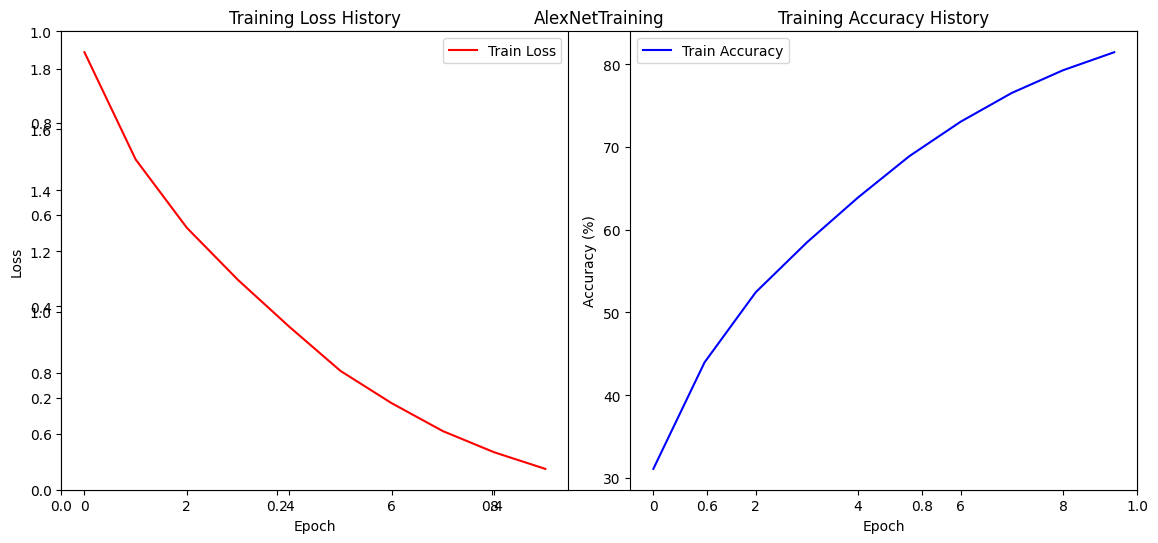

In [166]:
plot_acc_loss_for_training(train_loss_history_alexnet, train_accuracy_history_alexnet, "AlexNet" )

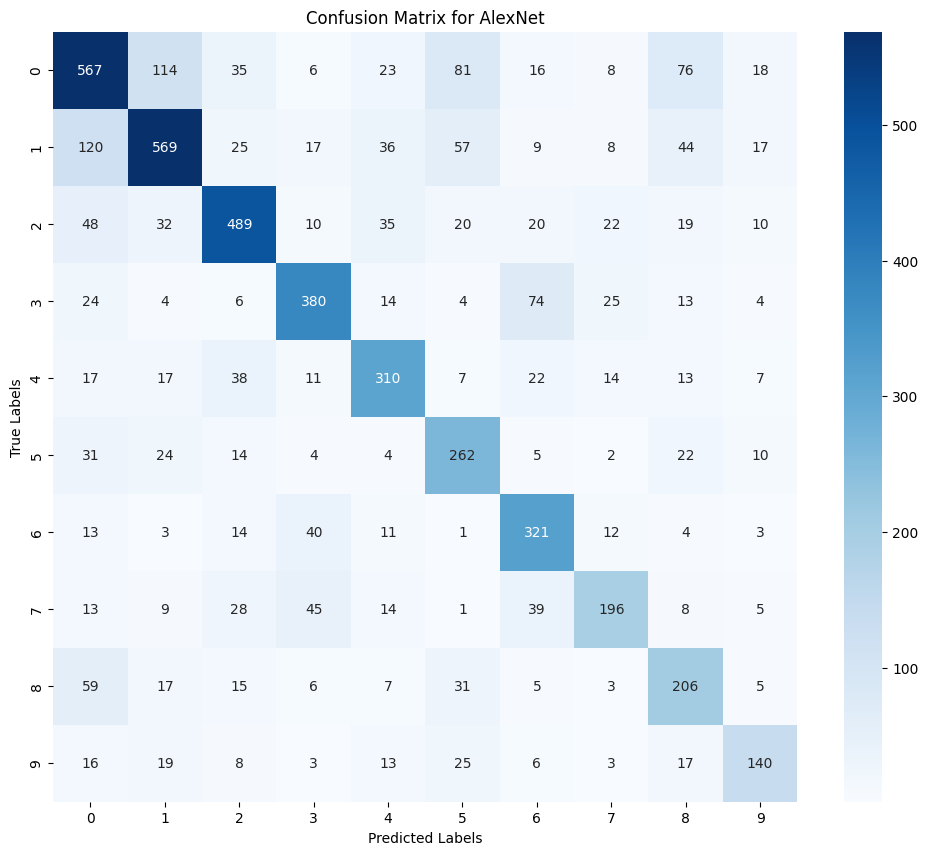

In [212]:
plot_heat_map(cm = confusion_matrix(y_true=y_test_alexnet, y_pred=y_pred_alexnet), model_name="AlexNet")

In [210]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"accuracy for AlexNet model is : {accuracy_score(y_true=y_test_alexnet, y_pred=y_pred_alexnet)}")

print(f"precision for AlexNet model is : {precision_score(y_true=y_test_alexnet, y_pred=y_pred_alexnet, average='macro',) }")

print(f"Recall for AlexNet model is : {recall_score(y_true=y_test_alexnet, y_pred=y_pred_alexnet, average='macro',) }")

print(f"F1-Score for AlexNet model is : {f1_score(y_true=y_test_alexnet, y_pred=y_pred_alexnet, average='macro',) }")

accuracy for AlexNet model is : 0.646981380477713
precision for AlexNet model is : 0.6401156857551237
Recall for AlexNet model is : 0.6441520369652884
F1-Score for AlexNet model is : 0.6388233057932784


<h1 style="color:#30e66a;">VGG 16 + SVM</h1>

In [51]:
vgg16 = models.vgg16(pretrained=True)

/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vgg16.eval()

In [ ]:
feature_extractor = nn.Sequential(vgg16.features, vgg16.avgpool)

In [401]:
feature_extractor.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from sklearn.svm import SVC

In [403]:
def extract_feature_from_tensor(tensor, feature_extractor=feature_extractor):
    with torch.no_grad():
        feature = feature_extractor(tensor.unsqueeze(0))
    return feature.squeeze(0)

In [404]:
def process_features_from_dataloader(dataloader):

    feature_list = []
    label_list = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            
            features = feature_extractor(images)
            
            batch_size = features.size(0)
            for i in range(batch_size):
                feature = features[i]
            
                flat_feature = feature.view(-1).cpu().numpy()
                
                feature_list.append(flat_feature)
                
                label_list.append(labels[i].item())

    
    feature_array = np.array(feature_list)
    label_array = np.array(label_list)
    return feature_array, label_array


In [ ]:
train_features_vgg_svm , train_labels_vgg_svm = process_features_from_dataloader(train_dataloader)

In [406]:
test_features_vgg_svm , test_labels_vgg_svm = process_features_from_dataloader(test_dataloader)

/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<h1 style="color:#30e66a;">CNN</h1>

In [75]:
CNN()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2)

In [88]:
class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6 , 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=10, bias=True),
        )

    def forward(self, x):
        features_output = self.features(x)
    
        if x.device.type == "mps":
            flatten_output = self.avgpool(features_output.cpu()).to(x.device)
        else:
            flatten_output = self.avgpool(features_output)
            
        flatten_output = flatten_output.view(x.size(0), -1)
        classlifier_output = self.classifier(flatten_output)
        return classlifier_output
        

In [89]:
CNN()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2)

In [90]:
import torch.nn as nn
import torch.optim as optim

def train_customize_cnn_classifier(train_dataloader, cnn_model ,class_weights_tensor, number_of_epochs=10):
    cnn_model.to(device)
    
    criterion = nn.CrossEntropyLoss(class_weights_tensor)
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

    train_loss_history = []
    train_accuracy_history = []

    for epoch in tqdm(range(number_of_epochs)):
        cnn_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cnn_model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = 100 * correct / total

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{number_of_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    return train_loss_history, train_accuracy_history


In [91]:
cnn_model = CNN()

In [92]:
train_loss_history_alexnet, train_accuracy_history_alexnet = train_customize_cnn_classifier(
    train_dataloader=train_dataloader, 
    cnn_model=cnn_model,
    class_weights_tensor=class_weights_tensor, 
    number_of_epochs=10
)

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/mahdi/Desktop/Deep-Learning/Project2/env/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|████▎                                      | 1/10 [06:23<57:30, 383.35s/it]

Epoch 1/10, Loss: 2.3063, Accuracy: 14.17%


 10%|███▌                                | 1/10 [6:33:11<58:58:41, 23591.23s/it]


KeyboardInterrupt: 